# **CT SCAN 3D Image Classification**

### **Setup**

Importing necessary modules and packages

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-07-26 12:38:36.752015: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


### **Dataset**

Downloading the [MosMedData: Chest CT Scans with COVID-19 Related Findings](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1) dataset which consists of lung CT scans with COVID-19 related findings, as well as without such findings. We will be using the associated radiological findings of the CT scans as labels to build a classifier to predict presence of viral pneumonia.

In [ ]:
# Download url of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

# Make a directory to store the data.
os.makedirs("MosMedData")

# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

### **Loading & Preprocessing data**

Files provided are of Nifti format with extension .nii which can be read using the ```nibabel``` package. CT Scans store raw voxel intensity in Hounsfield Units (HU) which range from -1024 to above 2000 in this dataset. Above 400 is used as a higher bound as these are bones with different radiointensity. CT Scans can be normalized with a threshold between -1000 and 400.

To process the data:
- We first rotate the volumes by 90 degrees, so the orientation is fixed
- We scale the HU values to be between 0 and 1.
- We resize width, height and depth.

So we design several helper functions to process the data and for building training and validation datasets.

In [3]:
import nibabel as nib
from scipy import ndimage

def read_nifti_file(filepath):
    """Read and load volume"""
    scan = nib.load(filepath)   # read file
    scan = scan.get_fdata()     # get raw data
    return scan

def normalize(volume):
    """Normalize volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    desired_depth = 64      # set desired depth
    desired_width = 128
    desired_height = 128

    current_depth = img.shape[-1]   # get current depth
    current_width = img.shape[0]
    current_height = img.shape[1]

    depth = current_depth / desired_depth   # compute depth factor
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    img = ndimage.rotate(img, 90, reshape=False)       # rotate
    
    # resize across z-axis
    img = ndimage.zoom(
        img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    volume = read_nifti_file(path)      # read scan
    volume = normalize(volume)      # normalize
    volume = resize_volume(volume)      # resize width, height and depth
    return volume

Reading paths of CT Scans from class directories

In [4]:
# CT Scans having normal lung tissue, no signs of viral pneumonia
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]

# CT Scans having ground-glass opacifications, involvement of lung parenchyma
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT Scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT Scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT Scans with normal lung tissue: 100
CT Scans with abnormal lung tissue: 100


### **Building Train & Validation datasets**

Read scans from class directories, Assign labels, Downsample scans to shape of 128x128x64, Rescale raw HU values to the range (0, 1) & Split dataset into train & validation subsets.

In [5]:
# read, process, resize & rescale scan across height, weight & depth
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

# assign 1 for presence of viral pneumonia & 0 for normal CT Scan
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# 70-30 data split for training & validation 
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


### **Data Augmentation**

To perform 3D Convolutions on the data, add 1 dimension of size 1 at axis 4 to the rank-3 tensors of shape ```(samples, height, width, depth)``` in the given data

In [6]:
import random
from scipy import ndimage

@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""
    def scipy_rotate(volume):
        angles = [-20, -10, -5, 5, 10, 20]       # define rotation angles
        angle = random.choice(angles)      # pick random angles
        
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    volume = rotate(volume)     # rotate volume
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

Training data is passed through an augmentation function which randomly rotates volume at different angles. Both training & validation data are already rescaled to have values between 0 & 1

In [7]:
# define data loaders
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2

# augment dataset on fly during training
training_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

# rescale
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

2022-07-26 12:59:21.975449: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-26 12:59:22.014896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 12:59:22.015334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design computeCapability: 7.5
coreClock: 1.335GHz coreCount: 24 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 268.26GiB/s
2022-07-26 12:59:22.015368: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-26 12:59:22.033652: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-26 12:59:22.033763: I tensorflo

Visualize augmented CT Scan

2022-07-26 12:59:23.413259: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 587202560 exceeds 10% of free system memory.
2022-07-26 12:59:23.810583: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-26 12:59:23.826528: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2601325000 Hz


Dimension of the CT SCan is:  (128, 128, 64, 1)


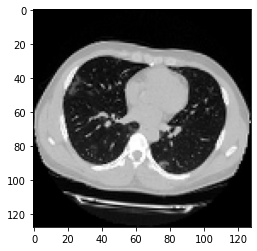

In [8]:
import matplotlib.pyplot as plt

data = training_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT SCan is: ", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

Visualize a montage of slices of CT Scan 

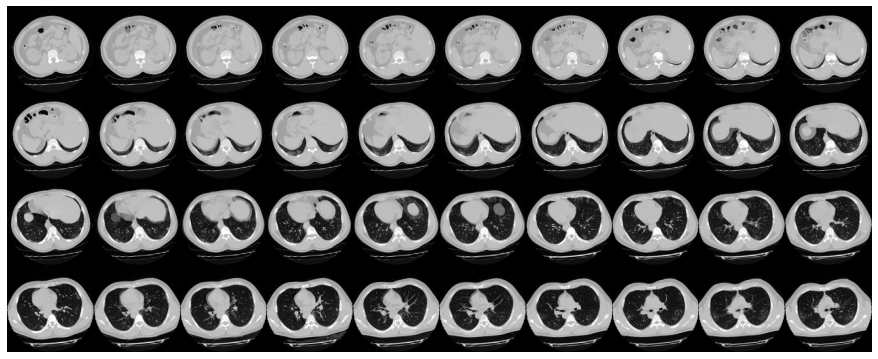

In [9]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# visualize 100 slices of the CT scan with 4 rows and 10 columns
plot_slices(4, 10, 128, 128, image[:, :, :40])

### **Define a 3D Convolutional Neural Network**

In [10]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model"""
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # define the model
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# build model
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

### **Training the Model**

In [11]:
# compile model
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# define callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_acc", patience=15)

# train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

2022-07-26 12:59:26.629652: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 587202560 exceeds 10% of free system memory.
2022-07-26 12:59:27.032057: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 587202560 exceeds 10% of free system memory.


Epoch 1/100


2022-07-26 12:59:28.845360: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-07-26 12:59:29.880583: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8401
2022-07-26 12:59:30.947317: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-26 12:59:30.947822: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


70/70 - 23s - loss: 0.6705 - acc: 0.5714 - val_loss: 1.2455 - val_acc: 0.5000
Epoch 2/100
70/70 - 19s - loss: 0.6657 - acc: 0.6286 - val_loss: 2.4246 - val_acc: 0.5000
Epoch 3/100
70/70 - 19s - loss: 0.6805 - acc: 0.6286 - val_loss: 2.4714 - val_acc: 0.5000
Epoch 4/100
70/70 - 19s - loss: 0.6604 - acc: 0.6214 - val_loss: 2.7446 - val_acc: 0.5000
Epoch 5/100
70/70 - 18s - loss: 0.6394 - acc: 0.6714 - val_loss: 1.7709 - val_acc: 0.5000
Epoch 6/100
70/70 - 19s - loss: 0.6737 - acc: 0.5929 - val_loss: 1.0249 - val_acc: 0.5000
Epoch 7/100
70/70 - 19s - loss: 0.6487 - acc: 0.5857 - val_loss: 2.0764 - val_acc: 0.5000
Epoch 8/100
70/70 - 18s - loss: 0.6417 - acc: 0.6071 - val_loss: 1.0331 - val_acc: 0.5000
Epoch 9/100
70/70 - 18s - loss: 0.6152 - acc: 0.7143 - val_loss: 0.7600 - val_acc: 0.5667
Epoch 10/100
70/70 - 19s - loss: 0.5905 - acc: 0.6786 - val_loss: 0.5626 - val_acc: 0.7167
Epoch 11/100
70/70 - 18s - loss: 0.6422 - acc: 0.6286 - val_loss: 0.5837 - val_acc: 0.6833
Epoch 12/100
70/70 -

### **Visualize Model performance**

Plotting model accuracy & loss for training & validation sets. Accuracy provides an unbiased representation of model's performance because validation set si class-balanced

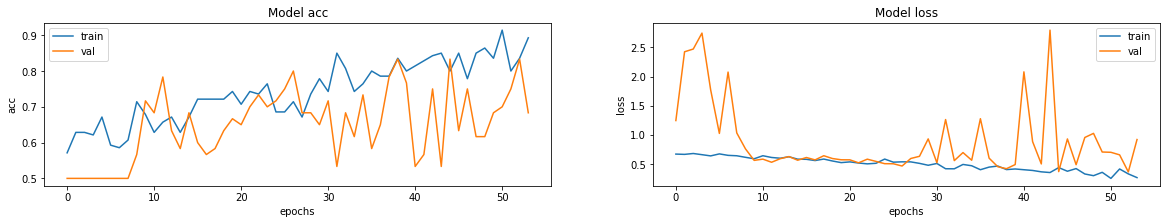

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

### **Make Predictions on a single CT Scan**

In [13]:
model.load_weights("3d_image_classification.h5")    # load best weights
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 83.86 percent confident that CT scan is normal
This model is 16.14 percent confident that CT scan is abnormal
